In [2]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import wave
#import pyaudio
import numpy as np
#import sounddevice as sd
from utils import *
import scipy
from scipy.signal import iirnotch, filtfilt
from glob import glob
import neurokit2 as nk


## Load Data

In [21]:
xdf_filename = '/Users/apurva.gokhe/Documents/CUNY_QC/data/sub-P5029423/sub-P5029423_ses-S001_task-CUNY_run-001_mobi.xdf'
subject = xdf_filename.split('-')[1].split('/')[0]
ps_df = get_event_data(event='Experiment',
                    df=import_physio_data(xdf_filename),
                    stim_df=import_stim_data(xdf_filename))

stim_df = import_stim_data(xdf_filename)

In [4]:
ps_df

,nSeq,RESPIRATION0,ECG1,EDA2,fSpO23,fSpO24,%SpO25,lsl_time_stamp,time
40087,664312.0,0.03516,-0.18131,7.0831,0.43636,1.05287,69.0,185787.714341,80.212008
40088,664313.0,0.03461,-0.17951,7.0862,0.43709,1.05286,69.0,185787.716342,80.214009
40089,664314.0,0.03516,-0.17592,7.0831,0.43729,1.05372,69.0,185787.718343,80.216009
40090,664315.0,0.03461,-0.17035,7.0816,0.43735,1.05306,69.0,185787.720344,80.218010
40091,664316.0,0.03479,-0.16532,7.0847,0.43689,1.05297,69.0,185787.722345,80.220011
...,...,...,...,...,...,...,...,...,...
1145407,1769632.0,0.02875,-0.10530,7.8308,0.41124,1.00380,72.0,187999.402325,2291.899991
1145408,1769633.0,0.02930,-0.12417,7.8323,0.41091,1.00375,72.0,187999.404326,2291.901992
1145409,1769634.0,0.03003,-0.13872,7.8308,0.41076,1.00377,72.0,187999.406327,2291.903993
1145410,1769635.0,0.03021,-0.14914,7.8323,0.40931,1.00373,72.0,187999.408328,2291.905994


## EDA

<Axes: xlabel='time', ylabel='EDA2'>

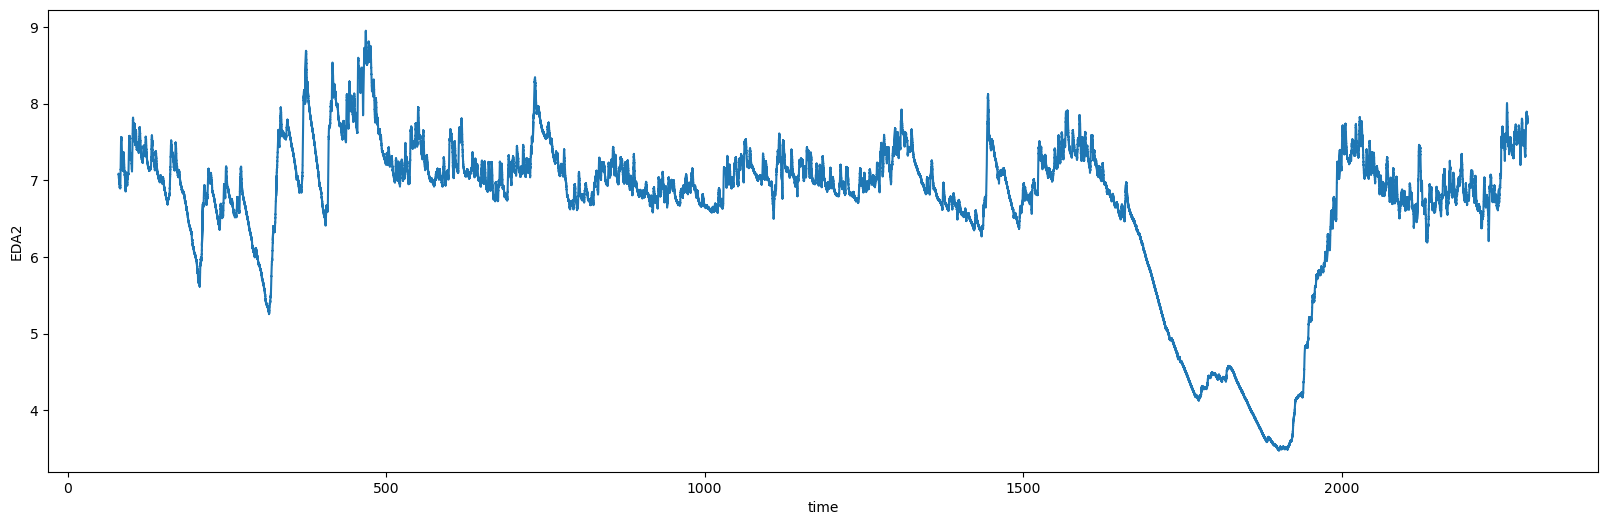

In [5]:
eda_df = ps_df[['EDA2', 'lsl_time_stamp', 'time']]
#ecg_resting_state = get_event_data('RestingState', ecg_df)
fig, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data=eda_df, x='time', y='EDA2')


## QC using neurokit2 package

In [6]:
effective_sampling_rate = 1 / (eda_df.lsl_time_stamp.diff().mean())
print('Effective sampling rate: ', effective_sampling_rate, 'Hz')

Effective sampling rate:  499.7630805945068 Hz


### Signal Integrity Check

In [7]:
# Checking for nan or missing values in EDA data and return a percentage validity

count_nan = 0
for x in eda_df['EDA2']:
    if np.isnan(x) == True:
        count_nan = count_nan + 1

eda_validity = 100 - (count_nan/len(eda_df['EDA2'])) * 100
print('Percentage of valid EDA data: ', eda_validity)

Percentage of valid EDA data:  100.0


### eda_process() - automated pipeline for preprocessing EDA signal, cleaning uses neurokit method

In [8]:
eda_signals, info = nk.eda_process(eda_df['EDA2'], sampling_rate=effective_sampling_rate, method='neurokit')
eda_signals

,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime
0,7.0831,7.082442,7.106663,-0.024221,0,0,0.0,0.0,0.0,0,0.0
1,7.0862,7.082330,7.106686,-0.024356,0,0,0.0,0.0,0.0,0,0.0
2,7.0831,7.082216,7.106709,-0.024493,0,0,0.0,0.0,0.0,0,0.0
3,7.0816,7.082099,7.106733,-0.024633,0,0,0.0,0.0,0.0,0,0.0
4,7.0847,7.081980,7.106756,-0.024775,0,0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1105320,7.8308,7.804795,7.576423,0.001708,0,0,0.0,0.0,0.0,0,0.0
1105321,7.8323,7.804797,7.576423,0.001576,0,0,0.0,0.0,0.0,0,0.0
1105322,7.8308,7.804798,7.576423,0.001445,0,0,0.0,0.0,0.0,0,0.0
1105323,7.8323,7.804799,7.576423,0.001312,0,0,0.0,0.0,0.0,0,0.0


## Skin Conductance Level

### Average SCL

In [9]:
# Calculating Mean of Skin Conductance Level (SCL), the tonic component of EDA signal 
scl_signal = eda_signals['EDA_Tonic']
average_scl = np.mean(scl_signal)
print('Average value of SCL: ', average_scl)

Average value of SCL:  6.721847165516104


### SCL Stability - standard deviation and coefficient of variation of SCL

In [10]:
# Calculating Standard deviation of Skin Conductance Level (SCL), the tonic component of EDA signal 
scl_sd = np.std(scl_signal)
print('Standard Deviation of SCL: ', scl_sd)

# Calculating Coeffecient of Variation of Skin Conductance Level (SCL), the tonic component of EDA signal 
scl_cv = scl_sd / average_scl
print('Coefficient of variation of SCL: ', scl_cv)

Standard Deviation of SCL:  0.974023023660114
Coefficient of variation of SCL:  0.14490407170471992


### SCL Trend Analysis

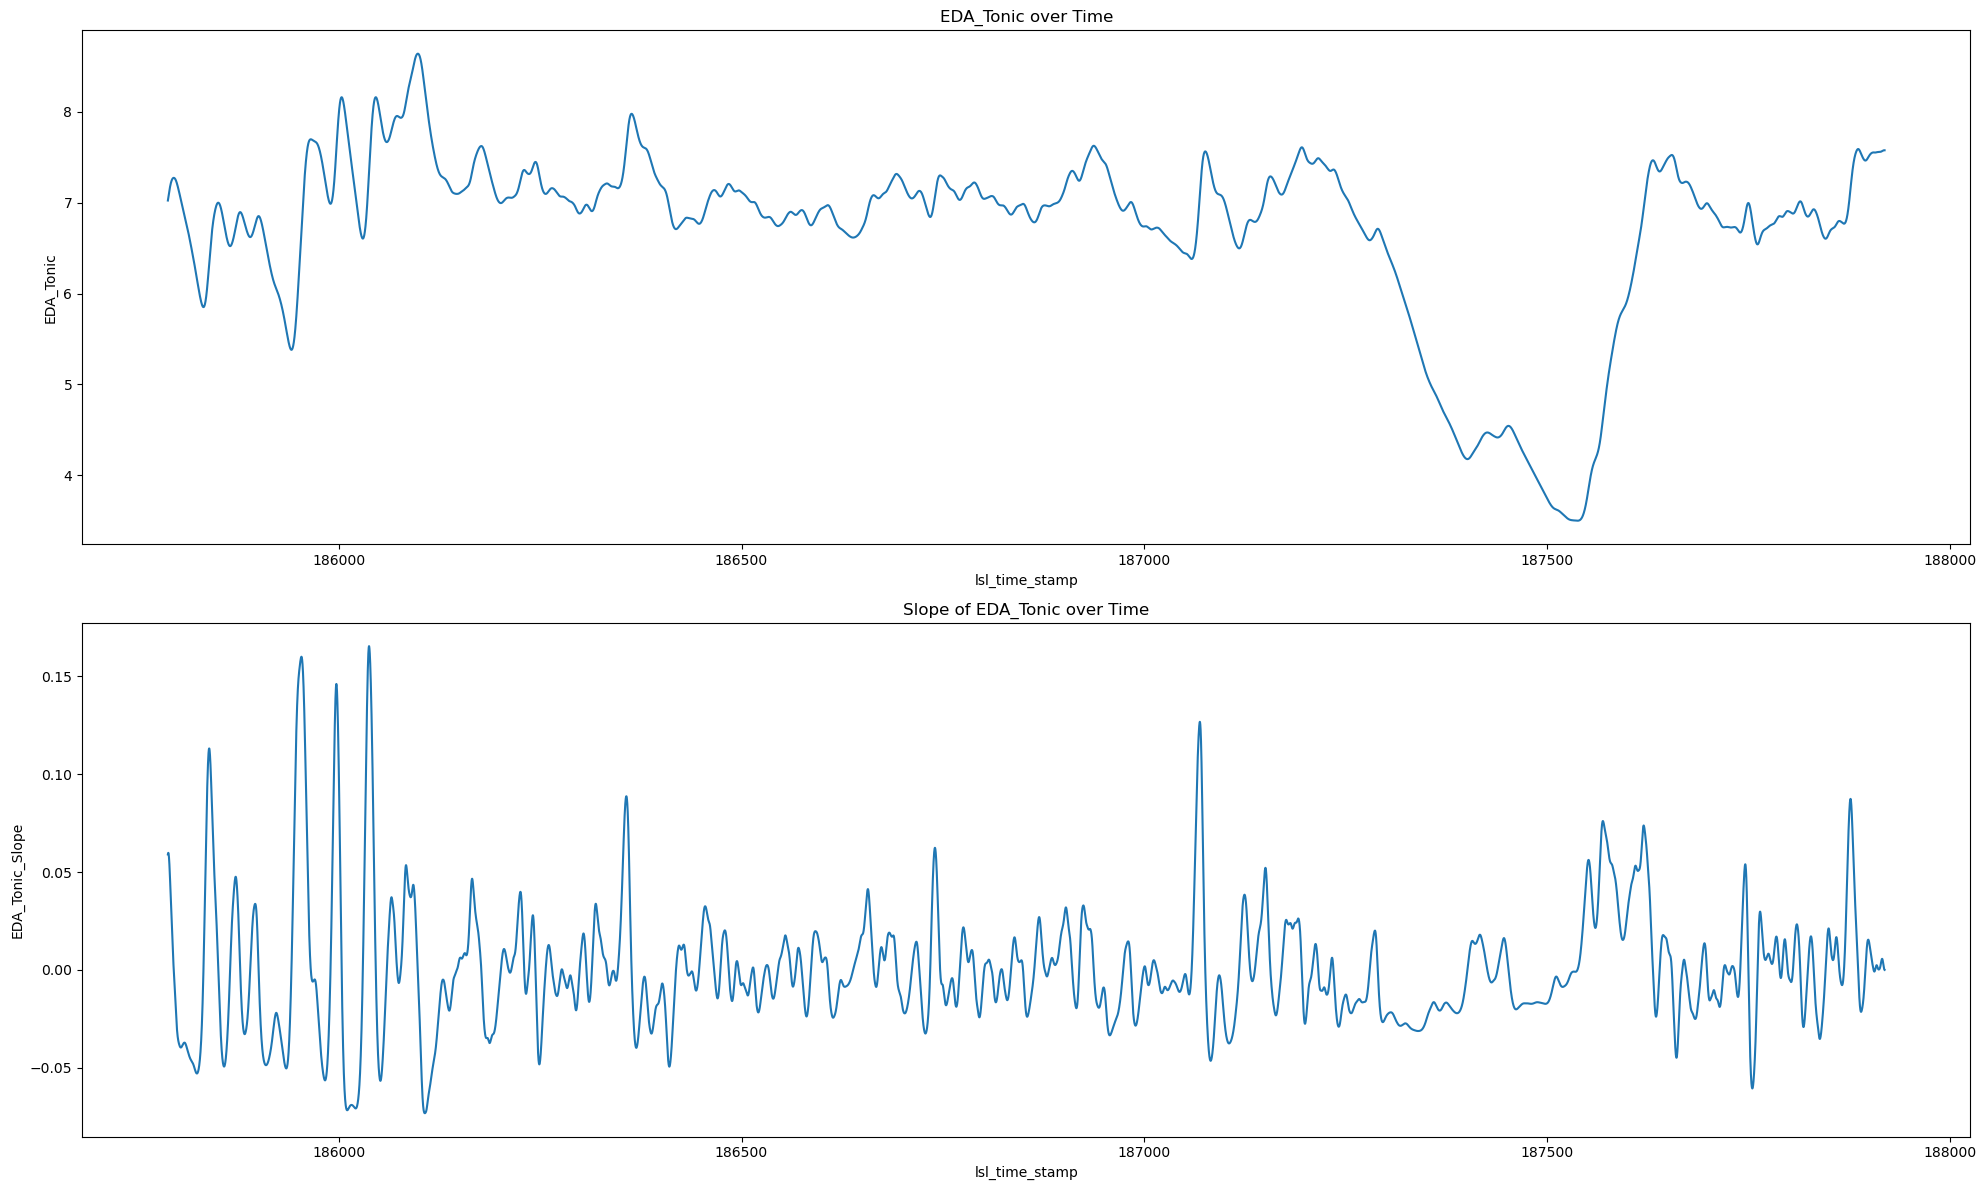

In [20]:
scl_df = pd.DataFrame(eda_signals['EDA_Tonic'])
scl_df['lsl_time_stamp'] = eda_df['lsl_time_stamp']
#fig, ax = plt.subplots(figsize=(20,6))
#sns.lineplot(data=scl_df, x='lsl_time_stamp', y='EDA_Tonic')

# Calcualting slope of SCL 
scl_df['EDA_Tonic_Slope'] = np.gradient(scl_df['EDA_Tonic'], scl_df['lsl_time_stamp'])

fig, ax = plt.subplots(2, 1, figsize=(20, 12))
sns.lineplot(data=scl_df, x='lsl_time_stamp', y='EDA_Tonic', ax=ax[0])
ax[0].set_title('EDA_Tonic over Time')

sns.lineplot(data=scl_df, x='lsl_time_stamp', y='EDA_Tonic_Slope', ax=ax[1])
ax[1].set_title('Slope of EDA_Tonic over Time')

plt.tight_layout()
plt.show()

## Skin Conductance Response

### Average amplitude of SCRs

In [12]:
scr_amplitudes = [amplitude for amplitude in info['SCR_Amplitude'] if np.isnan(amplitude) != True]
average_scr_amplitude = np.mean(scr_amplitudes)
print('Average amplitude of SCRs: ', average_scr_amplitude)

Average amplitude of SCRs:  0.25162199662911183


### SCR Amplitude Validity

In [13]:
count_invalid_scr = 0
for amplitude in scr_amplitudes:
    if amplitude > 0.01 and amplitude < 3.0:
        continue
    else:
        count_invalid_scr = count_invalid_scr + 1

scr_amplitude_validity = 100 - (count_invalid_scr/len(scr_amplitudes)) * 100
print('Percentage of valid SCR amplitudes: ', scr_amplitude_validity)


Percentage of valid SCR amplitudes:  96.6789667896679


### EDA report plot

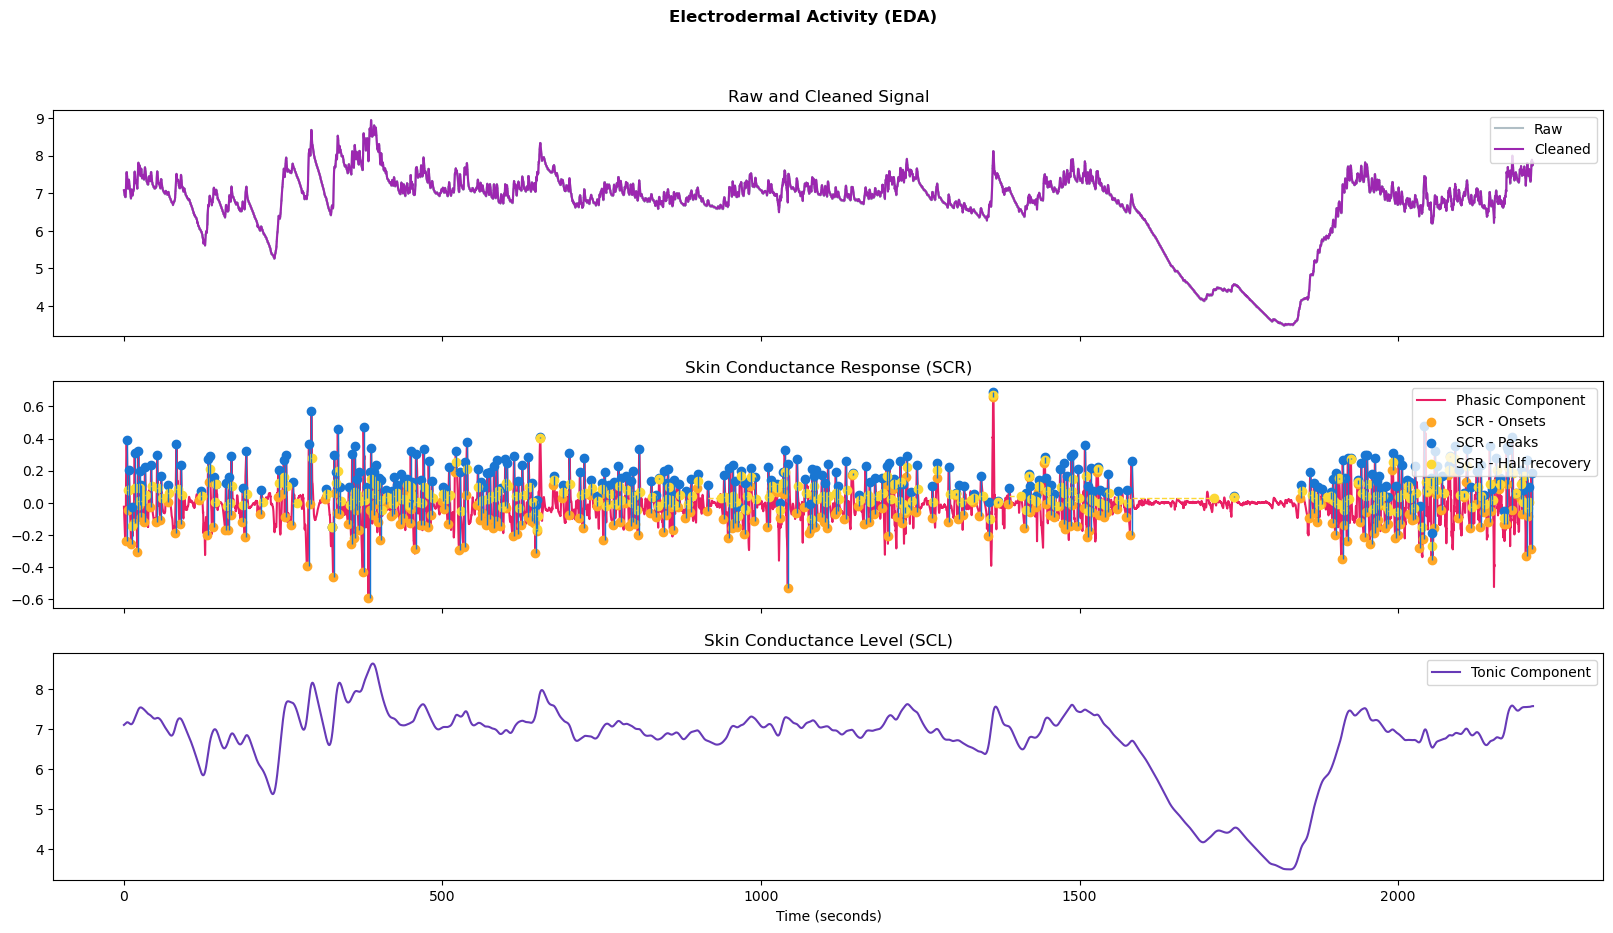

In [14]:
nk.eda_plot(eda_signals, info)
fig = plt.gcf()
axes = fig.get_axes()
fig.set_size_inches(20, 10)

## SNR calculation for EDA

Signal Power: 0.9685628495146633
Noise Power: 5.669396240903849e-06
SNR: 52.32590995687368 dB


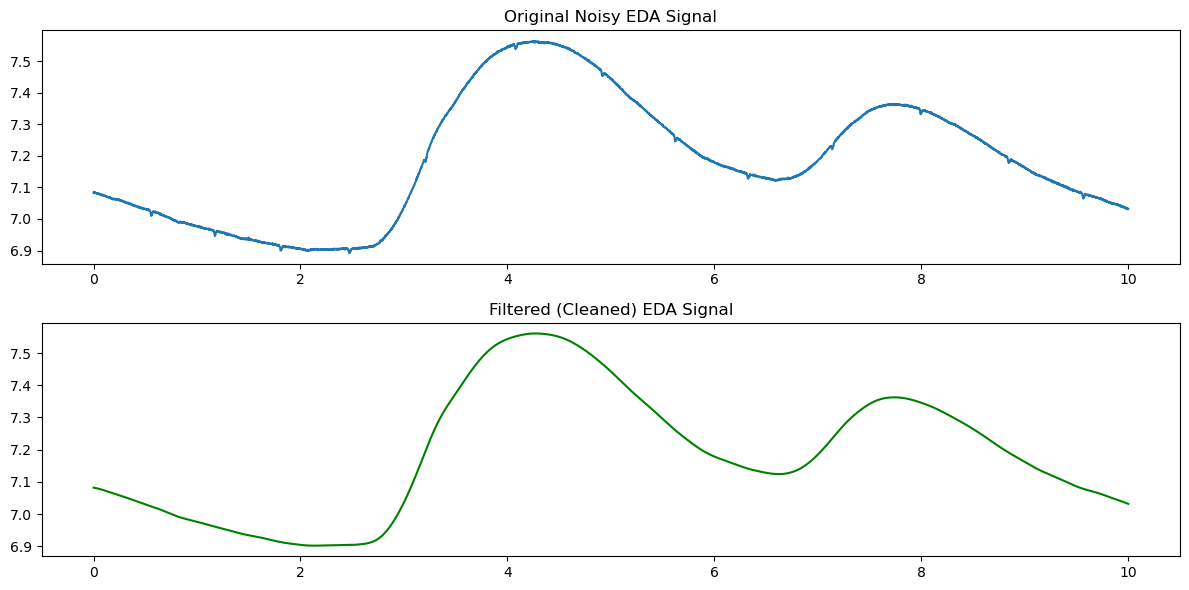

In [18]:
duration = len(eda_df['EDA2'].tolist()) / effective_sampling_rate
t = np.linspace(0, duration , len(eda_df['EDA2']))
t = t[:5000]

# Clean ECG from ecg_signals dataframe
eda_cleaned = eda_signals['EDA_Clean']

# Calculate signal power (variance of the cleaned ECG signal)
signal_power = np.var(eda_cleaned)

# Calculate signal power (mean of squared values)
#signal_power = np.mean(eda_cleaned**2)

# Estimate noise power (using residual noise after subtracting cleaned signal from raw noisy signal)
noise_signal = eda_signals['EDA_Raw'] - eda_cleaned  # residual noise
noise_power = np.var(noise_signal)
# Calculate noise power (mean of squared values)
#noise_power = np.mean(noise_signal**2)

# Calculate SNR (Signal-to-Noise Ratio in dB)
snr = 10 * np.log10(signal_power / noise_power)

# Output the results
print(f"Signal Power: {signal_power}")
print(f"Noise Power: {noise_power}")
print(f"SNR: {snr} dB")

# Plot the original noisy signal and the cleaned ECG signal for visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, eda_df['EDA2'].tolist()[:5000], label="Noisy EDA")
plt.title("Original Noisy EDA Signal")
plt.subplot(2, 1, 2)
plt.plot(t, eda_cleaned[:5000], label="Cleaned EDA", color='g')
plt.title("Filtered (Cleaned) EDA Signal")
plt.tight_layout()
plt.show()
